In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau

In [ ]:
#setting paths
train_path = "dataset2016/train/"
valid_path = "dataset2016/validation/"
test_path = "dataset2016/test/"

#vgg16 preprocessing function used to give better precision 
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=10, shuffle=False)
    
imgs, labels = next(train_batches)

In [3]:
model = Sequential([
    #just two conv layers to keep it a simple model 
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax'),
])
#model = load_model('models/best_model2016.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [4]:
# METRICS = [
#     keras.metrics.BinaryAccuracy(name="accuracy"),
#     keras.metrics.Precision(name="precision"),
#     keras.metrics.Recall(name="recall"),
#     keras.metrics.AUC(name="auc")
# ]

model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
#   metrics=METRICS
    )

In [5]:
train_examples = 811
test_examples = 379
validation_examples = 89
batch_size = 10
filepath="models/best_model2016.h5"

#callback functions
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

#training the model 
history = model.fit(
    x=train_batches,
    validation_data=valid_batches,
    epochs=30,
    verbose=1,
    callbacks=[checkpoint, early_stop, reduceLR, log_csv],
    steps_per_epoch=train_examples // batch_size,
    validation_steps=validation_examples // batch_size,
    )

Epoch 1/30
81/81 [==============================] - ETA: 0s - loss: 24.3924 - accuracy: 0.7291
Epoch 00001: val_loss improved from inf to 2.75933, saving model to models/best_model2016.h5
81/81 [==============================] - 30s 369ms/step - loss: 24.3924 - accuracy: 0.7291 - val_loss: 2.7593 - val_accuracy: 0.7500
Epoch 2/30
81/81 [==============================] - ETA: 0s - loss: 2.6104 - accuracy: 0.7840
Epoch 00002: val_loss did not improve from 2.75933
81/81 [==============================] - 30s 369ms/step - loss: 2.6104 - accuracy: 0.7840 - val_loss: 6.2550 - val_accuracy: 0.7500
Epoch 3/30
81/81 [==============================] - ETA: 0s - loss: 1.2705 - accuracy: 0.8202
Epoch 00003: val_loss improved from 2.75933 to 2.31445, saving model to models/best_model2016.h5
81/81 [==============================] - 29s 357ms/step - loss: 1.2705 - accuracy: 0.8202 - val_loss: 2.3145 - val_accuracy: 0.7500
Epoch 4/30
81/81 [==============================] - ETA: 0s - loss: 1.4622 - ac

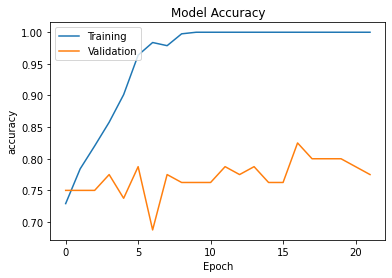

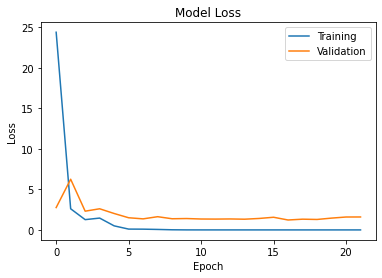

38/38 [==============================] - 11s 291ms/step - loss: 1.8617 - accuracy: 0.7836
[1.8616845607757568, 0.7836411595344543]


In [6]:
#plot model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
#plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


print(model.evaluate(test_batches))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

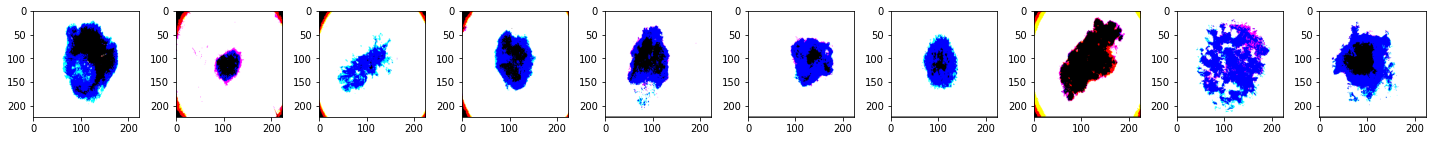

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [7]:
#plot images function 
#https://deeplizard.com/learn/video/14syUbL16k4
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes =axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

#predict test batch
predictions = model.predict(x=test_batches, verbose=0)
np.round(predictions)

Confusion matrix without normalization
[[284  20]
 [ 62  13]]


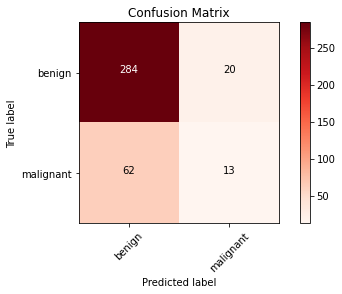

In [8]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

#function for confusion matrix taken from scikit-learn website
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix without normalization")
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm_plot_labels = ['benign','malignant'] #setting labels
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [10]:
from sklearn.metrics import classification_report

y_pred=np.argmax(predictions, axis=-1)

#this gives precision, recall, f1 score and accuracy scores
print(classification_report(test_batches.classes, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       304
           1       0.39      0.17      0.24        75

    accuracy                           0.78       379
   macro avg       0.61      0.55      0.56       379
weighted avg       0.74      0.78      0.75       379



In [ ]:
#print(test_labels)
test_batches.class_indices